In [2]:
import h5py
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
from scipy import stats
import glob, os
import datetime as dt
from scipy.signal import find_peaks, peak_prominences

In [3]:
def unnesting(df, explode):
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([
        pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx

    return df1.join(df.drop(explode, 1), how='left')

I don't kno wnothingMC70_3-12-19_L3_crossing6_patternB_light1DLC_resnet101_LadderWalkFeb13shuffle1_1030000.h5


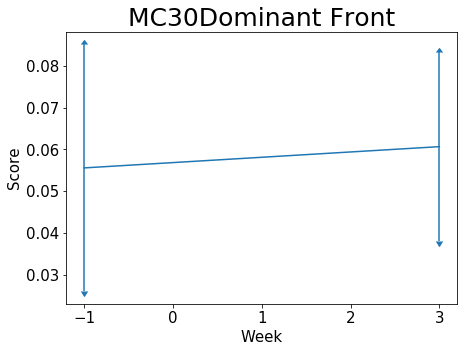

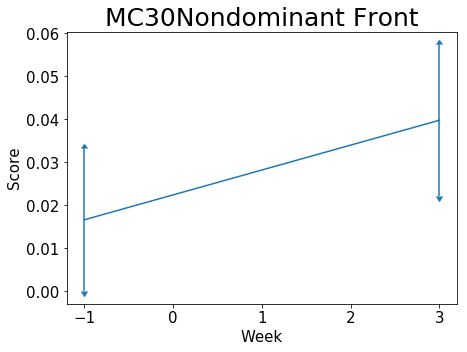

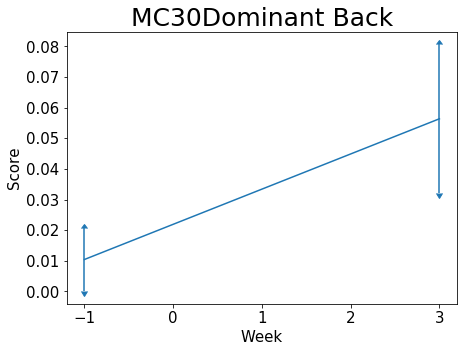

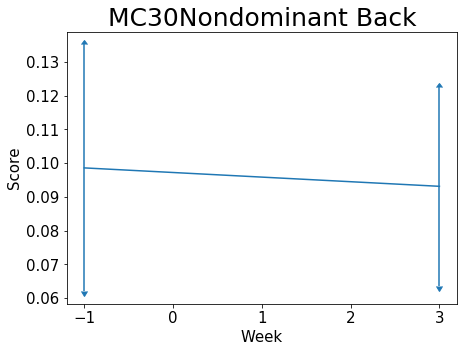

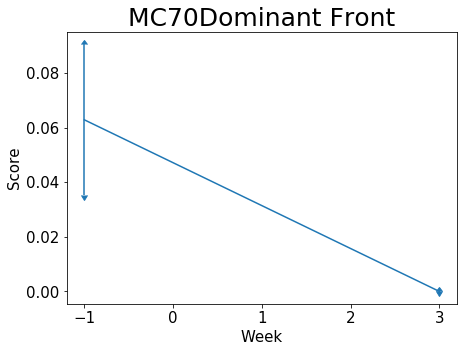

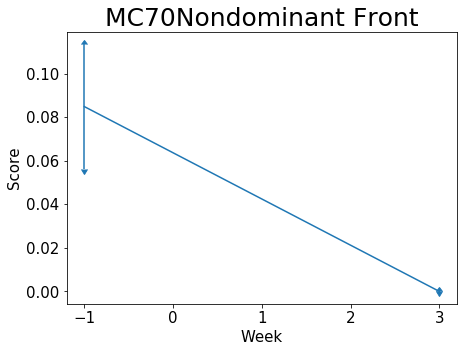

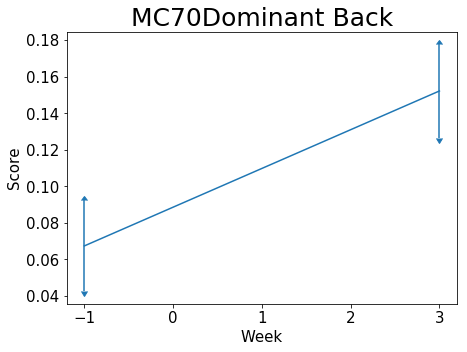

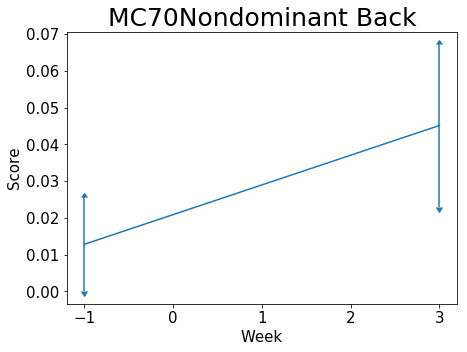

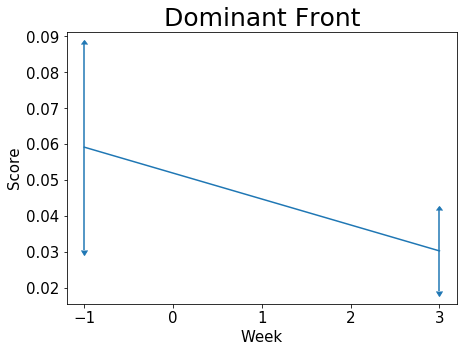

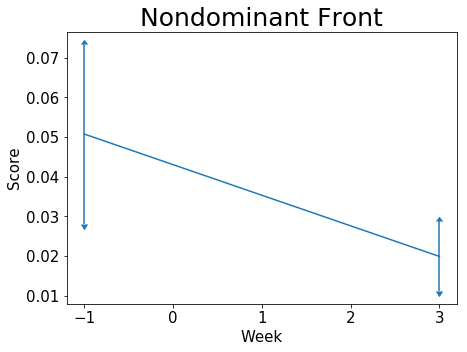

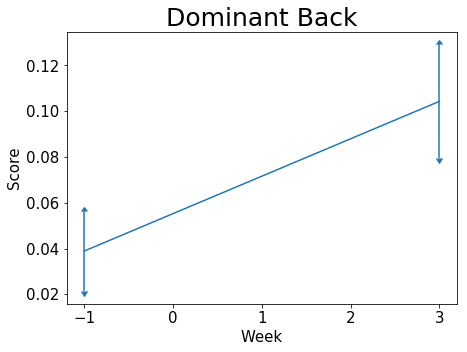

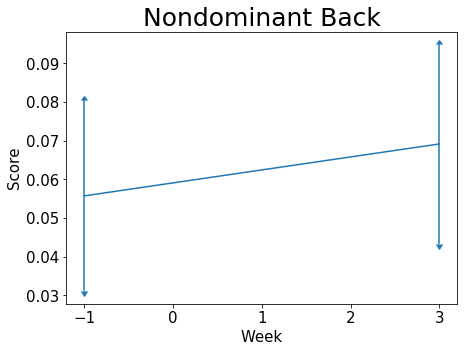

In [13]:
subjects = ["MC30","MC70"]
appended = []
for subject in subjects:
    folder = "/home/ml/Documents/Not_TADSS_Videos/"+subject+"/cut/dlc_output_16-810"
    folder2 = "/home/ml/Documents/z_scoring/"+subject+"/"
    #empty list of files
    files = []
    os.chdir(folder)
    injured = "Front Right"
    for file in glob.glob("*.h5"):
        files.append(file)
        #print(file)
    peaks_l = []
    peaks_r = []
    peakcols_l = ["subject","date","run","peak_fl_x","peak_fl_y","likelihood_fl","peak_bl_x","peak_bl_y","likelihood_bl","z-score_fl","z-score_bl"]
    peakcols_r = ["subject","date","run","peak_fr_x","peak_fr_y","likelihood_fr","peak_br_x","peak_br_y","likelihood_br","z-score_fr","z-score_br"]
    xdist = -20
    likes_fr = []
    likes_fl = []
    likes_bl = []
    likes_br = []
    for data in files:
        subject = data.split("_")[0]
        date = data.split("_")[1]
        run = data.split("_")[2]
        df = pd.read_hdf(data)
        pred = 0.1
        promperc = 40
        dh = 25

        #left
        if run[0]=='L':
            df_fl = df['DLC_resnet101_LadderWalkFeb13shuffle1_1030000']['left fingers']
            df_bl = df['DLC_resnet101_LadderWalkFeb13shuffle1_1030000']['left toes']

            likes_fl.append(df_fl["likelihood"].values)
            likes_bl.append(df_bl["likelihood"].values)
            df_fl = df_fl.loc[df_fl['likelihood']>pred]
            df_fl = df_fl.reset_index()
            df_fl.name = "Front Left"
            df_bl = df_bl.loc[df_bl['likelihood']>pred]
            df_bl = df_bl.reset_index()
            df_bl.name = "Back Left"
            like_fl = df_fl["likelihood"]
            like_bl = df_bl["likelihood"]
            x_fl = df_fl["x"]
            y_fl = df_fl["y"]
            x_bl = df_bl["x"]
            y_bl = df_bl["y"]
            peaks_fl = find_peaks(y_fl,prominence=0)
            proms_fl = peaks_fl[1]['prominences']
            if len(proms_fl)>=1:
                prom_fl = np.percentile(proms_fl,promperc).min()
            else:
                prom_fl = 0
            peaks_bl = find_peaks(y_bl,prominence=0)
            proms_bl = peaks_bl[1]['prominences']

            if len(proms_bl)>=1:
                prom_bl = np.percentile(proms_bl,promperc).min()
            else:
                prom_bl = 0
            med_fl = np.median(y_fl)
            peaks_fl= find_peaks(y_fl, height = med_fl-dh, prominence=prom_fl)
            med_bl = np.median(y_bl)
            peaks_bl= find_peaks(y_bl, height = med_bl-dh, prominence=prom_bl)
            zsc_fl = (np.abs(stats.zscore(y_fl[peaks_fl[0]])))
            zsc_bl = (np.abs(stats.zscore(y_bl[peaks_bl[0]])))
            peaks_l.append([subject,date,run,x_fl[peaks_fl[0]],y_fl[peaks_fl[0]],like_fl[peaks_fl[0]],x_bl[peaks_bl[0]],y_bl[peaks_bl[0]],like_bl[peaks_bl[0]],zsc_fl,zsc_bl])
            xdist_df_l = pd.DataFrame([[subject,date,run,x_fl[peaks_fl[0]],y_fl[peaks_fl[0]],like_fl[peaks_fl[0]],x_bl[peaks_bl[0]],y_bl[peaks_bl[0]],like_bl[peaks_bl[0]],zsc_fl,zsc_bl]],columns=peakcols_l)
            xdist_df_l["daterun"] = xdist_df_l["date"].map(str) +" "+ xdist_df_l["run"]
            frontl_df = unnesting(xdist_df_l[['subject','daterun','peak_fl_x','peak_fl_y']],['peak_fl_x','peak_fl_y'])
            backl_df = unnesting(xdist_df_l[['subject','daterun','peak_bl_x','peak_bl_y']],['peak_bl_x','peak_bl_y'])
            frontl_df = frontl_df.sort_values(["peak_fl_x"],ascending=False)
            frontl_df["diff"]=frontl_df.groupby(["subject","daterun"])["peak_fl_x"].diff()
            frontl_df["keep"] = "Y"
            frontl_df.loc[(frontl_df["diff"])>xdist,"keep"] = "N"
            frontl_df = frontl_df.loc[frontl_df["keep"]=="Y"]
            backl_df = backl_df.sort_values(["peak_bl_x"],ascending=False)
            backl_df["diff"]=backl_df.groupby(["subject","daterun"])["peak_bl_x"].diff()
            backl_df["keep"] = "Y"
            backl_df.loc[(backl_df["diff"])>xdist,"keep"] = "N"
            backl_df = backl_df.loc[backl_df["keep"]=="Y"]
        #right
        elif run[0]=='R':
            df_fr = df['DLC_resnet101_LadderWalkFeb13shuffle1_1030000']['right fingers']
            df_br = df['DLC_resnet101_LadderWalkFeb13shuffle1_1030000']['right toes']    
            likes_fr.append(df_fr["likelihood"].values)
            likes_br.append(df_br["likelihood"].values)
            df_fr = df_fr.loc[df_fr['likelihood']>pred]
            df_fr = df_fr.reset_index()
            df_fr.name = "Front Right"
            df_br = df_br.loc[df_br['likelihood']>pred]
            df_br = df_br.reset_index()
            df_br.name = "Back Right"
            like_fr = df_fr["likelihood"]
            like_br = df_br["likelihood"]
            x_fr = df_fr["x"]
            y_fr = df_fr["y"]
            x_br = df_br["x"]
            y_br = df_br["y"]
            peaks_fr = find_peaks(y_fr,prominence=0)
            proms_fr = peaks_fr[1]['prominences']
            if len(proms_fr)>=1:
                prom_fr = np.percentile(proms_fr,promperc).min()
            else:
                prom_fr = 0
            peaks_br = find_peaks(y_br,prominence=0)
            proms_br = peaks_br[1]['prominences']
            if len(proms_br)>=1:
                prom_br = np.percentile(proms_br,promperc).min()
            else:
                prom_br = 0
            med_fr = np.median(y_fr)
            peaks_fr= find_peaks(y_fr, height = med_fr-dh, prominence=prom_fr)
            med_br = np.median(y_br)
            peaks_br= find_peaks(y_br, height = med_br-dh, prominence=prom_br)
            zsc_fr = (np.abs(stats.zscore(y_fr[peaks_fr[0]])))
            zsc_br = (np.abs(stats.zscore(y_br[peaks_br[0]])))
            peaks_r.append([subject,date,run,x_fr[peaks_fr[0]],y_fr[peaks_fr[0]],like_fr[peaks_fr[0]],x_br[peaks_br[0]],y_br[peaks_br[0]],like_br[peaks_br[0]],zsc_fr,zsc_br])
            xdist_df_r = pd.DataFrame([[subject,date,run,x_fr[peaks_fr[0]],y_fr[peaks_fr[0]],like_fr[peaks_fr[0]],x_br[peaks_br[0]],y_br[peaks_br[0]],like_br[peaks_br[0]],zsc_fr,zsc_br]],columns=peakcols_r)
            xdist_df_r["daterun"] = xdist_df_r["date"].map(str) +" "+ xdist_df_r["run"]
            frontr_df = unnesting(xdist_df_r[['subject','daterun','peak_fr_x','peak_fr_y']],['peak_fr_x','peak_fr_y'])
            backr_df = unnesting(xdist_df_r[['subject','daterun','peak_br_x','peak_br_y']],['peak_br_x','peak_br_y'])
            frontr_df = frontr_df.sort_values(["peak_fr_x"],ascending=False)
            frontr_df["diff"]=frontr_df.groupby(["subject","daterun"])["peak_fr_x"].diff()
            frontr_df["keep"] = "Y"
            frontr_df.loc[(frontr_df["diff"])>xdist,"keep"] = "N"
            frontr_df = frontr_df.loc[frontr_df["keep"]=="Y"]
            backr_df = backr_df.sort_values(["peak_br_x"],ascending=False)
            backr_df["diff"]=backr_df.groupby(["subject","daterun"])["peak_br_x"].diff()
            backr_df["keep"] = "Y"
            backr_df.loc[(backr_df["diff"]>xdist),"keep"] = "N"
            backr_df = backr_df.loc[backr_df["keep"]=="Y"]
        else:
            print("I don't kno w"+run+file)

    df2_l = pd.DataFrame(peaks_l,columns=peakcols_l)
    df2_l["daterun"] = df2_l["date"].map(str) +" "+ df2_l["run"]
    fl = unnesting(df2_l[["subject",'daterun','peak_fl_x','peak_fl_y',"likelihood_fl","z-score_fl"]],['peak_fl_x','peak_fl_y',"likelihood_fl","z-score_fl"])
    fl = fl[["subject",'daterun','peak_fl_x','peak_fl_y',"likelihood_fl","z-score_fl"]]
    fl = fl.rename(columns={"daterun":"daterun","peak_fl_x":"x","peak_fl_y":"y","likelihood_fl":"likelihood","z-score_fl":"z-score"})
    fl["limb"] = "Front Left"
    fl = fl.reset_index()
    fl = fl.drop("index",axis=1)

    peak_df_fl = fl
    peak_df_fl = peak_df_fl.sort_values(["daterun","x"],ascending=False)
    peak_df_fl["diff"]=peak_df_fl.groupby(["subject","daterun","limb"])["x"].diff()
    peak_df_fl["keep"] = "Y"
    peak_df_fl.loc[(peak_df_fl["diff"])>xdist,"keep"] = "N"
    peak_df_fl = peak_df_fl.loc[peak_df_fl["keep"]=="Y"]

    bl = unnesting(df2_l[["subject",'daterun','peak_bl_x','peak_bl_y',"likelihood_bl","z-score_bl"]],['peak_bl_x','peak_bl_y',"likelihood_bl","z-score_bl"])
    bl = bl[["subject",'daterun','peak_bl_x','peak_bl_y',"likelihood_bl","z-score_bl"]]
    bl = bl.rename(columns={"daterun":"daterun","peak_bl_x":"x","peak_bl_y":"y","likelihood_bl":"likelihood","z-score_bl":"z-score"})
    bl["limb"] = "Back Left"
    bl = bl.reset_index()
    bl = bl.drop("index",axis=1)

    peak_df_bl = bl
    peak_df_bl = peak_df_bl.sort_values(["daterun","x"],ascending=False)
    peak_df_bl["diff"]=peak_df_bl.groupby(["subject","daterun","limb"])["x"].diff()
    peak_df_bl["keep"] = "Y"
    peak_df_bl.loc[(peak_df_bl["diff"]>xdist),"keep"] = "N"
    peak_df_bl = peak_df_bl.loc[peak_df_bl["keep"]=="Y"]

    df2_r = pd.DataFrame(peaks_r,columns=peakcols_r)
    df2_r["daterun"] = df2_r["date"].map(str) +" "+ df2_r["run"]

    fr = unnesting(df2_r[["subject","daterun","peak_fr_x","peak_fr_y","likelihood_fr","z-score_fr"]],['peak_fr_x','peak_fr_y',"likelihood_fr","z-score_fr"])
    fr = fr[["subject","daterun","peak_fr_x","peak_fr_y","likelihood_fr","z-score_fr"]]
    fr = fr.rename(columns={"daterun":"daterun","peak_fr_x":"x","peak_fr_y":"y","likelihood_fr":"likelihood","z-score_fr":"z-score"})
    fr["limb"] = "Front Right"
    fr = fr.reset_index()
    fr = fr.drop("index",axis=1)

    peak_df_fr = fr
    peak_df_fr = peak_df_fr.sort_values(["daterun","x"],ascending=False)
    peak_df_fr["diff"]=peak_df_fr.groupby(["subject","daterun","limb"])["x"].diff()
    peak_df_fr["keep"] = "Y"
    peak_df_fr.loc[(peak_df_fr["diff"])>xdist,"keep"] = "N"
    peak_df_fr = peak_df_fr.loc[peak_df_fr["keep"]=="Y"]



    br = unnesting(df2_r[["subject",'daterun','peak_br_x','peak_br_y',"likelihood_br","z-score_br"]],['peak_br_x','peak_br_y',"likelihood_br","z-score_br"])
    br = br[["subject",'daterun','peak_br_x','peak_br_y',"likelihood_br","z-score_br"]]
    br = br.rename(columns={"daterun":"daterun","peak_br_x":"x","peak_br_y":"y","likelihood_br":"likelihood","z-score_br":"z-score"})
    br["limb"] = "Back Right"
    br = br.reset_index()
    br = br.drop("index",axis=1)

    peak_df_br = br
    peak_df_br = peak_df_br.sort_values(["daterun","x"],ascending=False)
    peak_df_br["diff"]=peak_df_br.groupby(["subject","daterun","limb"])["x"].diff()
    peak_df_br["keep"] = "Y"
    peak_df_br.loc[(peak_df_br["diff"])>xdist,"keep"] = "N"
    peak_df_br = peak_df_br.loc[peak_df_br["keep"]=="Y"]



    concatlist = [peak_df_fr,peak_df_fl,peak_df_br,peak_df_bl]
    newdf = pd.concat(concatlist)
    #newdf.to_csv(folder2+"/"+subject+"_peaks.csv")

    zreq = 2
    zreq_injured = 2
    #was 0.6

    zdf = newdf.drop(["z-score"],axis = 1)
    #recalculate z-score of peaks using all the limbs
    zdf2 = zdf.groupby(['subject','daterun']).y.transform(lambda x : np.abs(stats.zscore(x)))
    zdf['z-score'] = zdf2

    hitdf = zdf.loc[ (zdf['z-score']<=zreq) | ((zdf['z-score']<=zreq_injured) & (zdf['limb']==injured))].groupby(['subject','daterun','limb'])['z-score'].count()
    slipdf = zdf.loc[ (zdf['z-score']>zreq) | ((zdf['z-score']>zreq_injured) & (zdf['limb']==injured))].groupby(['subject','daterun','limb'])['z-score'].count()


    scoredf = pd.DataFrame()
    scoredf['dlc_hits'] = hitdf
    scoredf['dlc_slips'] = slipdf
    scoredf = scoredf.fillna(0)
    scoredf['dlc_steps'] = scoredf['dlc_hits'].add(scoredf['dlc_slips'])
    scoredf = scoredf.reset_index()
    scoredf[['date',"run"]] = scoredf.daterun.str.split(expand=True)
    scoredf = scoredf.drop("daterun",axis=1)
    scoredf = scoredf[["subject","date","run","limb","dlc_hits","dlc_slips","dlc_steps"]]
    scoredf['date'] = pd.to_datetime(scoredf["date"])

    scoredf['limb'] = scoredf['limb'].replace({"Front Left":"Nondominant Front","Front Right":"Dominant Front","Back Left":"Nondominant Back","Back Right":"Dominant Back"})
    df = scoredf
    df["dlc_score"] = df["dlc_slips"]/df["dlc_steps"]
    df_wk = df
    df_wk["date"] = pd.to_datetime(df_wk["date"])
    if subject == "MC30":
        date1 = dt.datetime(2019,11,12)
    elif subject == "MC70":
        date1 = dt.datetime(2019,3,19)
    df_wk["week"] = (df_wk["date"] - date1).dt.days/7
    df_wk = df_wk.round({"week":0})
    df_summ = df_wk.groupby(["subject","week","limb"])["dlc_score"].agg(["mean","sem"])
    df_summ = df_summ.reset_index()

    appended.append(df_summ)


    fd = df_summ.loc[df_summ["limb"] == "Dominant Front"]

    fn = df_summ.loc[df_summ["limb"] =="Nondominant Front"]

    bd = df_summ.loc[df_summ["limb"] =="Dominant Back"]

    bn = df_summ.loc[df_summ["limb"] =="Nondominant Back"]

    limbs = [fd,fn,bd,bn]
    for limb in limbs:
        limb = limb.reset_index()
        name = limb["limb"][0]
        plt.figure()
        plt.rcParams["figure.figsize"] = (7,5)
        plt.rc('xtick',labelsize=15)
        plt.rc('ytick',labelsize=15)
        plt.errorbar(limb["week"],limb["mean"],yerr=limb["sem"] , uplims=True, lolims=True)
        plt.title( subject + name ,fontsize=25)
        plt.xlabel("Week",fontsize=15)
        plt.ylabel("Score",fontsize=15)
        plt.savefig("/home/ml/Documents/"+subject + name+"visible_weekly_score.png")
df_main=pd.concat(appended)

df_new = df_main.groupby(["week","limb"]).mean()
df_new = df_new.reset_index()
df_new = df_new.sort_values(by=["week"])

fd = df_new.loc[df_new["limb"] == "Dominant Front"]

fn = df_new.loc[df_new["limb"] =="Nondominant Front"]

bd = df_new.loc[df_new["limb"] =="Dominant Back"]

bn = df_new.loc[df_new["limb"] =="Nondominant Back"]

limbs = [fd,fn,bd,bn]
for limb in limbs:
    limb=limb.reset_index()
    name = limb["limb"][0]
    plt.figure()
    plt.rcParams["figure.figsize"] = (7,5)
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    plt.errorbar(limb["week"],limb["mean"],yerr=limb["sem"], uplims=True, lolims=True)
    plt.title( name ,fontsize=25)
    plt.xlabel("Week",fontsize=15)
    plt.ylabel("Score",fontsize=15)
    plt.savefig("/home/ml/Documents/"+name+"visible_weekly_score.png")

                                      

In [5]:
y_br[peaks_br[0]]

6     647.236816
10    644.334351
14    647.942749
20    643.663330
25    658.801880
Name: y, dtype: float64

In [6]:
subject

'MC70'

In [11]:
run

'L3'